In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-wz6acltv
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-wz6acltv
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=ab24725b69446a0665a9efcfdcffe520d2770126b202ca95853cbac96cff968c
  Stored in directory: /tmp/pip-ephem-wheel-cache-3ev74x6v/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import h5py
from collections import defaultdict
from glob import glob
from random import choice,sample
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
#!unzip /content/drive/MyDrive/TDL_PROJECT/train.zip -d /content/drive/MyDrive/TDL_PROJECT/train

In [ ]:
!pip install keras.vggface

In [ ]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 3.0 MB/s 


In [ ]:
!pip install keras_preprocessing

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

#from keras_vggface.vggface import VGGFace

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-l450_1vv
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-l450_1vv
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=4011cd5c33ce2808ef69a938df737c490dbf206d4a0df705293412787978c0ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-k6tjj6qu/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 2.6 MB/s 


In [ ]:
import tensorflow as tf
import keras
import tensorflow.python.keras.engine
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Input,Dense,GlobalMaxPool2D,GlobalAvgPool2D,Concatenate,Multiply,Dropout,Subtract,Lambda
from keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.optimizers import Adam
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from keras import backend as K
from keras.models import load_model

In [ ]:
train_file_path='/content/drive/MyDrive/Dataset/train_relationships.csv'
train_folders_path='/content/drive/MyDrive/Dataset/train/'
val_families='F09' #families which has F09*** in folder name

In [ ]:
%%time
#/content/drive/MyDrive/TDL_PROJECT/train/F0002/MID1/P00009_face3.jpg
all_images=glob(train_folders_path+'*/*/*.jpg') #paths of all images
train_images=[x for x in all_images if val_families not in x] #path of images used for training
val_images=[x for x in all_images if val_families in x] #path of validation images (belonging to families starting with F09)

CPU times: user 242 ms, sys: 207 ms, total: 449 ms
Wall time: 1.53 s


In [ ]:
ppl=[x.split('/')[-3]+'/'+x.split("/")[-2] for x in all_images] #obtaining the people in the format give in train_relationship

In [ ]:
#Mapping people to their faces (list of faces)
train_person_to_images_map=defaultdict(list)
for x in train_images:
  train_person_to_images_map[x.split('/')[-3]+'/'+x.split("/")[-2]].append(x)

val_person_to_images_map=defaultdict(list)
for x in val_images:
  val_person_to_images_map[x.split('/')[-3]+'/'+x.split('/')[-2]].append(x)

In [ ]:
#Obtaining relationship pairs and converting them to tuples
relationships = pd.read_csv(train_file_path)
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

In [ ]:
#Diving the tuples into train and validation
train=[x for x in relationships if val_families not in x[0]]
val=[x for x in relationships if val_families in x[0]]

In [ ]:
#reads the image and converts into numpy aarray and finally returns the image processed as required by VGGFace
def img2arr(path):
  img=cv2.imread(path)
  img=np.array(img).astype(np.float)
  return preprocess_input(img)

In [ ]:
#Generator to use with fit_generator to generate data in batches
def data_generator(list_tuples,person_to_images_map,batch_size=16):
  ppl=list(person_to_images_map.keys())
  while True:
    batch_tuples=sample(list_tuples,batch_size//2)
    labels=[1]*len(batch_tuples)
    while len(batch_tuples)<batch_size:
      p1=choice(ppl)
      p2=choice(ppl)

      if p1!=p2 and (p1,p2) not in list_tuples and (p2,p1) not in list_tuples:
        batch_tuples.append((p1,p2))
        labels.append(0)
    for x in batch_tuples:
      if not len(person_to_images_map[x[0]]):
        print(x[0])
    X1=[choice(person_to_images_map[x[0]]) for x in batch_tuples]
    X1=np.array([img2arr(x) for x in X1])
    X2=[choice(person_to_images_map[x[1]]) for x in batch_tuples]
    X2=np.array([img2arr(x) for x in X2])
    labels = np.asarray(labels).reshape((-1,1))
    yield [X1,X2],labels

In [ ]:
#Model architecture
def build_model():
  input1=Input(shape=(224,224,3))
  input2=Input(shape=(224,224,3))

  #defining the base model
  base_model=VGGFace(model='resnet50',include_top=False)

  
  #sister networks
  x1=base_model(input1)
  x2=base_model(input2)

  x1=Concatenate(axis=-1)([GlobalMaxPool2D()(x1),GlobalAvgPool2D()(x1)])
  x2=Concatenate(axis=-1)([GlobalMaxPool2D()(x2),GlobalAvgPool2D()(x2)])

  #euclidean distance measure
  x3=Subtract()([x1,x2])
  x3=Multiply()([x3,x3])
  #x=Multiply()([x3,x3])
  
  #manhattan distance measure with square of each point
  #x=Multiply()([x1,x2])
  x1_=Multiply()([x1,x1])
  x2_=Multiply()([x2,x2])
  x4=Subtract()([x1_,x2_])

  #regularization
  x5=Multiply()([x1,x2])

  x=Concatenate(axis=-1)([x3,x4,x5])

  x=Dense(100,activation='relu')(x) #batch normalization
  x=Dropout(0.01)(x)
  out=Dense(1,activation='sigmoid')(x)
  

  model=Model([input1,input2],out)

  model.compile(loss='binary_crossentropy',metrics=['acc'],optimizer=Adam(0.00001))

  model.summary()

  return model

In [ ]:
file_path='/content/drive/MyDrive/Dataset/vgg_face_1.h5'

In [ ]:
#Using callbacks
checkpoint=ModelCheckpoint(file_path,monitor='val_acc',verbose=1,save_best_only=True,mode='max') #Saves the best model based on val_acc

reduce_lr_on_plateau=ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.1,patience=20,verbose=1) #Reduces the learning rate when val_acc is not improving

callbacks_list=[checkpoint,reduce_lr_on_plateau]

In [ ]:
model=build_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vggface_resnet50 (Functional)  (None, None, None,   23561152    ['input_7[0][0]',                
                                2048)                             'input_8[0][0]']          

In [ ]:
history=model.fit_generator(data_generator(train,train_person_to_images_map,batch_size=16),\
                    use_multiprocessing=True,\
                    validation_data=data_generator(val, val_person_to_images_map, batch_size=16),\
                    epochs=5,verbose=1,workers=4,callbacks=callbacks_list,steps_per_epoch=50,validation_steps=50)

Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 4.4602 - acc: 0.5975
Epoch 1: val_acc improved from -inf to 0.56750, saving model to /content/drive/MyDrive/Dataset/vgg_face_1.h5
50/50 [==============================] - 57s 728ms/step - loss: 4.4602 - acc: 0.5975 - val_loss: 7.8688 - val_acc: 0.5675 - lr: 1.0000e-05
Epoch 2/5
50/50 [==============================] - ETA: 0s - loss: 3.8433 - acc: 0.6012
Epoch 2: val_acc improved from 0.56750 to 0.57375, saving model to /content/drive/MyDrive/Dataset/vgg_face_1.h5
50/50 [==============================] - 34s 692ms/step - loss: 3.8433 - acc: 0.6012 - val_loss: 6.3762 - val_acc: 0.5738 - lr: 1.0000e-05
Epoch 3/5
50/50 [==============================] - ETA: 0s - loss: 3.6852 - acc: 0.5875
Epoch 3: val_acc improved from 0.57375 to 0.59625, saving model to /content/drive/MyDrive/Dataset/vgg_face_1.h5
50/50 [==============================] - 36s 726ms/step - loss: 3.6852 - acc: 0.5875 - val_loss: 4.9484 - val_acc: 0.5962 - l

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


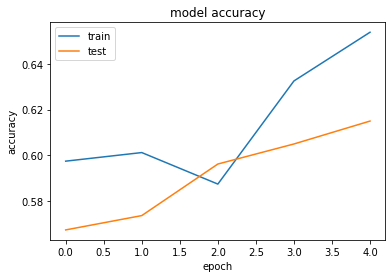

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pickle
with open('/content/drive/MyDrive/Dataset/history.pkl','wb') as f:
  pickle.dump(history,f)

INFO:tensorflow:Assets written to: ram://1b835c72-506c-43a8-b8da-4e8649c6968f/assets


In [ ]:
#saving the model
model.save('/content/drive/My Drive/Recognizing_Faces_in_the_Wild/vggface.h5')

In [ ]:
model=load_model('/content/drive/My Drive/Recognizing_Faces_in_the_Wild/vggface.h5')

In [ ]:
test_path='/content/drive/My Drive/Recognizing_Faces_in_the_Wild/test/'

In [ ]:
submission=pd.read_csv('/content/drive/My Drive/Recognizing_Faces_in_the_Wild/sample_submission.csv',header=0)

In [ ]:
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [ ]:
#generates test data in batches
def test_batch(test_pairs,size=32):
  return (test_pairs[pos:pos+size] for pos in range(0,len(test_pairs),size))

In [ ]:
predictions=[]

for batch in tqdm(test_batch(submission.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([img2arr(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([img2arr(test_path + x) for x in X2])

    pred = model.predict([X1, X2]).ravel().tolist()
    predictions += pred

submission['is_related'] = predictions

166it [25:04,  9.06s/it]


In [ ]:
submission.to_csv("/content/drive/My Drive/Recognizing_Faces_in_the_Wild/20190824/predictions.csv", index=False)

<strong>Note</strong>

Used features (x1-x2)^2, (x1^2 - x2^2) and (x1*x2) 

Used different validation sets while training five models and took the average of predictions of all models to improve the score.

